In [93]:
import pandas as pd
from pathlib import Path
import os
import librosa
import librosa.display
import librosa.feature as feat
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from scipy import signal
import seaborn as sns
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline

In [94]:
# Set the path to the downloaded data
download_path = Path.cwd() / ".dataset"

# Read labels file
labels_file = download_path / "Y_train_ofTdMHi.csv"
df = pd.read_csv(labels_file)

# Construct file path by concatenating folder and file name
df["relative_path"] = str(download_path) + "/X_train/" + df["id"]

# Drop id column (replaced it with relative_path)
df.drop(columns=["id"], inplace=True)

df.rename(columns={"pos_label": "label"}, inplace=True)

# invert relative_path and label columns positions
df = df[["relative_path", "label"]]
display(ipd.Markdown(f"### There are **_{len(df)}_** audio files in the dataset."))

# separate good and bad signals
df_bad  = df[df["label"] == 0]
df_good = df[df["label"] == 1]

table = f"""
Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | {df['label'].value_counts()[0]} |
| 1       | {df['label'].value_counts()[1]} |"""
display(ipd.Markdown(table))

### There are **_23168_** audio files in the dataset.


Here is the split into good and bad signals:
| Label   | Count   |
|:-------:|:-------:|
| 0       | 13718 |
| 1       | 9450 |

/var/folders/fq/416crnp14t900prd5913_8700000gn/T/ipykernel_1016/242955492.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, ax=ax, palette=["#e74c3c", "#38AD2B"])
/var/folders/fq/416crnp14t900prd5913_8700000gn/T/ipykernel_1016/242955492.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.xaxis.set_ticklabels(["Sans clic", "Avec clic"])


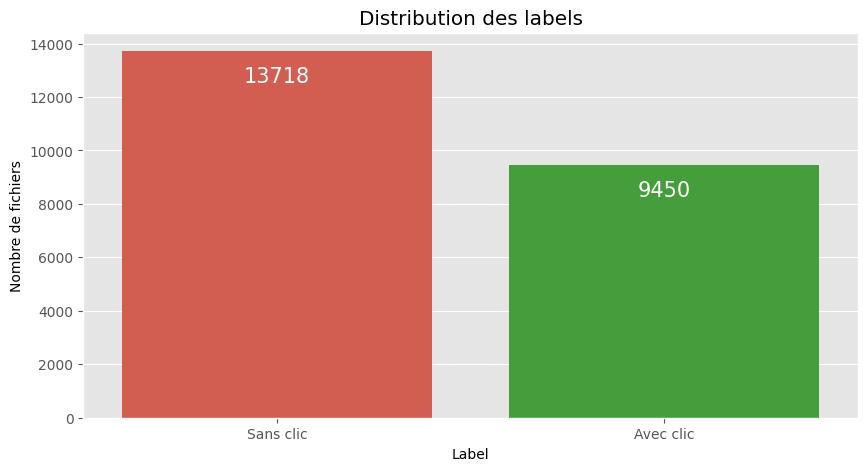

In [95]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use("ggplot")   
sns.countplot(x="label", data=df, ax=ax, palette=["#e74c3c", "#38AD2B"])
ax.xaxis.set_ticklabels(["Sans clic", "Avec clic"])
ax.set_title("Distribution des labels")
ax.set_xlabel("Label")
ax.set_ylabel("Nombre de fichiers")
# Display the numbers above each bar
for p in ax.patches:
    ax.annotate(
        round(p.get_height()),
        ((p.get_x() + p.get_width() / 2), p.get_height()-1200),
        color="white", 
        size=15,
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.show()

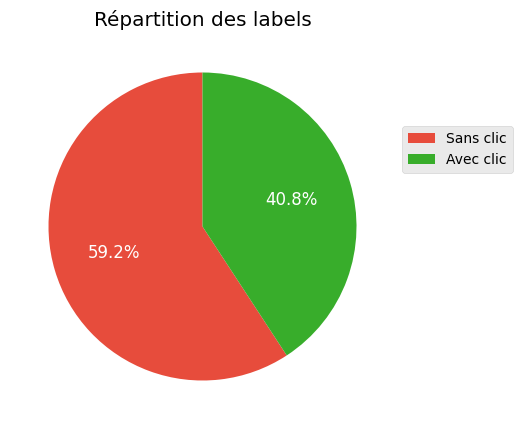

In [96]:
plt.figure(figsize=(10, 5))
plt.style.use("ggplot")
plt.title("Répartition des labels")
plt.pie(
    df["label"].value_counts(),
    autopct="%1.1f%%",
    colors=["#e74c3c", "#38AD2B"],
    startangle=90,
    textprops={"fontsize": 12, "color": "white"},
)
plt.legend(["Sans clic", "Avec clic"], loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))

plt.show()

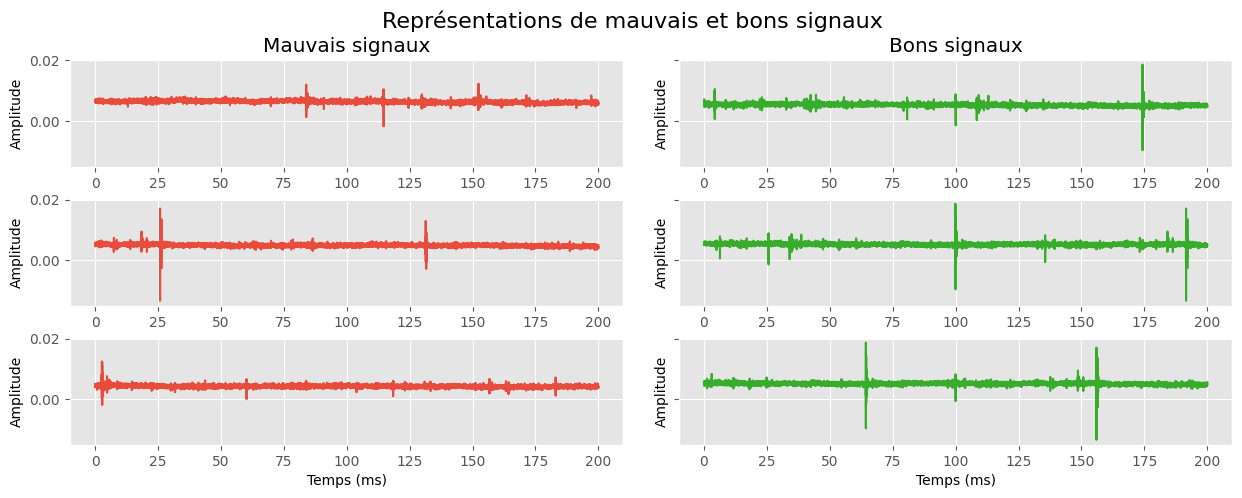

In [97]:

file_paths = [[df_bad.iloc[i]["relative_path"], df_good.iloc[i]["relative_path"]] for i in range(10)]
file_labels= [[df_bad.iloc[i]["relative_path"], df_good.iloc[i]["relative_path"]] for i in range(10)]
audio_data1, sr1 = librosa.load(file_paths[0][0], sr=None)

duration = librosa.get_duration(y=audio_data1, sr=sr1)
time = np.linspace(0, duration*1000, len(audio_data1))

# Plot the audio signal
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 5), sharey=True, sharex=False, gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
fig.suptitle("Représentations de mauvais et bons signaux", fontsize=16)

for i in range(3):
    for j in range(2):
        
        ax[i][j].set_ylabel("Amplitude")
ax[2][0].set_xlabel("Temps (ms)")
ax[2][1].set_xlabel("Temps (ms)")
for row in range(3):
    for col in range(2):
        signal, sr = librosa.load(file_paths[row][col], sr=None)
        ax[row][col].plot(time,signal, color=f"{'#e74c3c' if col==0 else '#38AD2B'}")

ax[0][0].set_title("Mauvais signaux")
ax[0][1].set_title("Bons signaux")

plt.show()

/Users/tristangclvs/Documents/ENSC/3A/S9/Spé IA/projet/spe_ia_clics_odontocetes/.venv/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


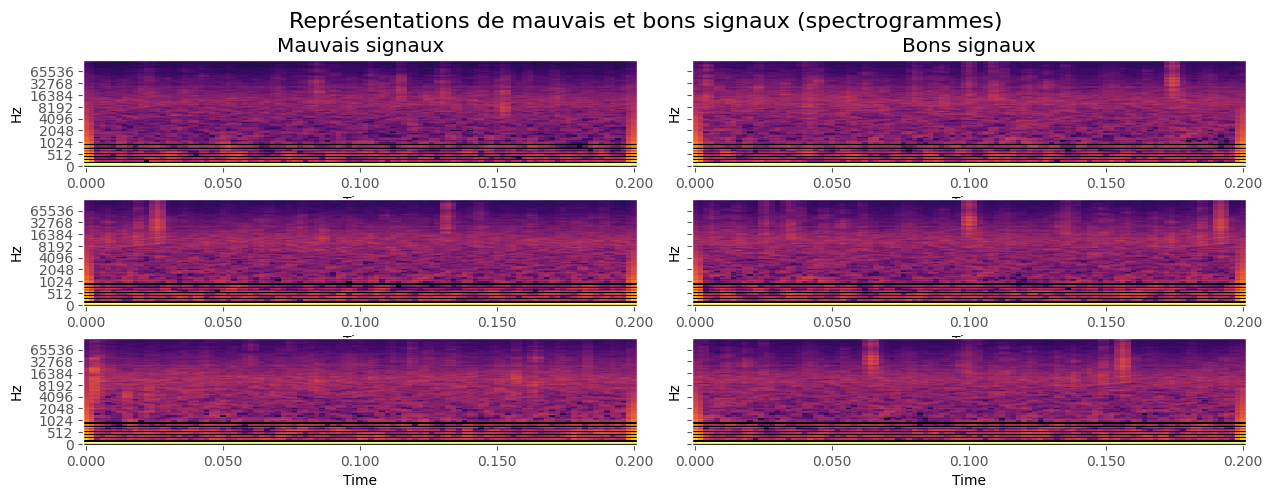

In [108]:
# Plot the audio signal
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 5), sharey=True, sharex=False, gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
fig.suptitle("Représentations de mauvais et bons signaux (spectrogrammes)", fontsize=16)


for row in range(3):
    for col in range(2):
        # Get spectrogram using librosa
        signal, sr = librosa.load(file_paths[row][col], sr=None)
        S = librosa.feature.melspectrogram(y=signal, sr=sr)
        S_DB = librosa.power_to_db(S, ref=np.max)
        librosa.display.specshow(S_DB, sr=sr, x_axis="time", y_axis="mel", ax=ax[row][col], cmap="inferno")

ax[0][0].set_title("Mauvais signaux")
ax[0][1].set_title("Bons signaux")

plt.show()

Text(0.5, 1.0, 'Bons signaux')

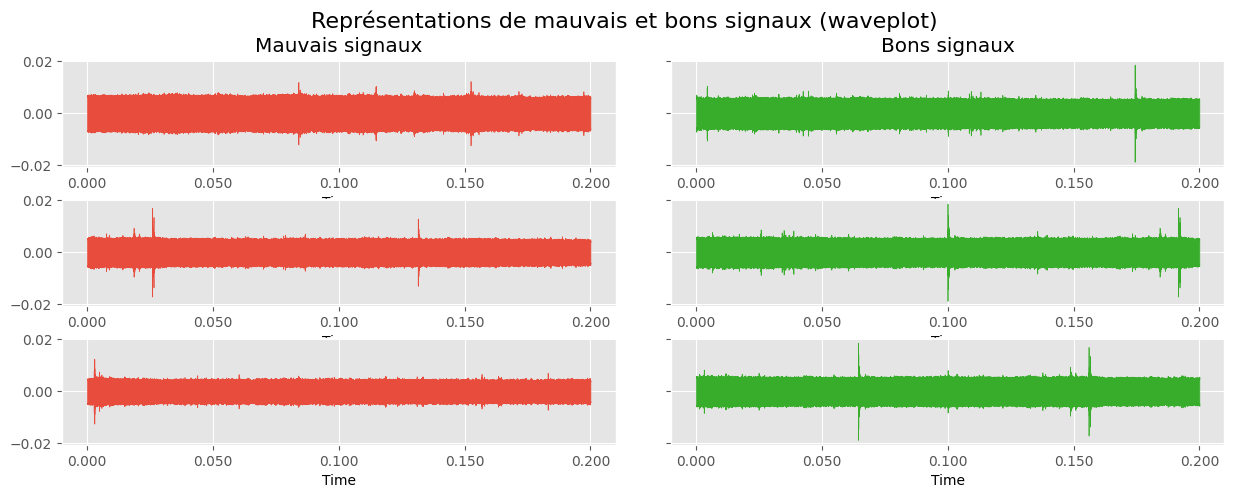

In [109]:
# Plot waveplots
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 5), sharey=True, sharex=False, gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
fig.suptitle("Représentations de mauvais et bons signaux (waveplot)", fontsize=16)


for row in range(3):
    for col in range(2):
        # Get spectrogram using librosa
        signal, sr = librosa.load(file_paths[row][col], sr=None)
        librosa.display.waveshow(signal, sr=sr, ax=ax[row][col], color=f"{'#e74c3c' if col==0 else '#38AD2B'}")

ax[0][0].set_title("Mauvais signaux")
ax[0][1].set_title("Bons signaux")